# Training a Quadcopter to Takeoff using Reinforcement Learning

## The Task

The task specified is Takeoff i.e. the quadcopter has to liftoff the ground and reach a certain height. 

## Reinforcement Learning

I have used the same DDPG Process that has been explained here. After a number of trial I have picked $\gamma$ as 0.9
I have a standard NN architecture with 3 hidden layers and relu and tanh activations

The advantage of DDPG is that it is off-policy and model-free. It optimize a policy end-to-end by computing noisy estimates of the gradient of the expected reward and then updating the policy in the gradient direction. The Actor-Critic learning algorithm is used to represent the policy function. The policy function structure is known as the actor, and the value function structure is the critic. The actor produces an action given the current state and the critic produces a error given the state and reward.

In general, training and evaluating policy with a number of simulated trajectories leads to high variance in the approximation of the Q-function. A experience replay is useful to store the experiences of the agent during training, and then randomly sample experiences for learning and break up the temporal correlations within different training episodes. 

Q targets are used to decouple the targets from the parameters thus making oscillations less likely. The OU Noise is added to the actions to encourage exploratory behavior and prevent actions from varying wildly. Also the OU process tends to settle down close to the specified mean over time

The reward function is based on the z_velocity and the motion in z from initial position. The reward was clipped between -1 and and 1. The negative reward was given for crashing and a positive for reaching the desired height

## Training

In [15]:
%reload_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
from agents.agent import DDPGProcess
from TakeoffTask import Takeoff

num_episodes = 300
init_pose = np.array([0., 0., 1., 0., 0., 0.])
target_pos = np.array([0., 0., 15.])
task = Takeoff(init_pose=init_pose,target_pos=target_pos)
agent = DDPGProcess(task) 

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}
data = {x : [] for x in ['episode', 'total_reward', 'x', 'y', 'z']}

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action=action, reward=reward, next_state=next_state, done=done)
        state = next_state
        
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])

        if done:
            print("\rEpisode ={:4d}, score ={:7.3f} (best ={:7.3f}) (Pose ={:7.3f},{:7.3f},{:7.3f}{:7.3f},{:7.3f},{:7.3f})".format(
                i_episode, agent.score, agent.best_score, task.sim.pose[0], task.sim.pose[1], task.sim.pose[2], task.sim.pose[3], task.sim.pose[4], task.sim.pose[5]), end="")  # [debug]

            data['episode'].append(i_episode)
            data['total_reward'].append(agent.total_reward)
            data['x'].append(task.sim.pose[0])
            data['y'].append(task.sim.pose[1])
            data['z'].append(task.sim.pose[2])

            break
    sys.stdout.flush()

Episode = 300, score =103.824 (best =104.199) (Pose =  0.000,  0.000, 15.345  0.000,  0.000,  0.000)

## Plot the Rewards

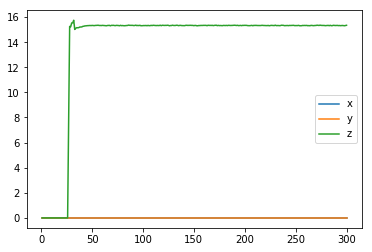

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(data['episode'], data['x'], label='x')
plt.plot(data['episode'], data['y'], label='y')
plt.plot(data['episode'], data['z'], label='z')
plt.legend()
_ = plt.ylim()

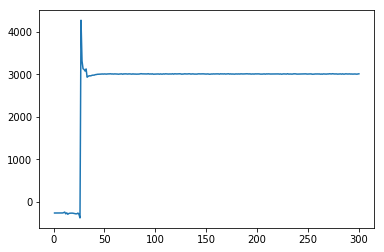

In [21]:
plt.plot(data['episode'], data['total_reward'])
plt.legend()
_ = plt.ylim()